In [1]:
import numpy as np
import pandas as pd
import math
from scipy.stats import norm
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
import joblib
from sklearn.model_selection import train_test_split
import time
import matplotlib.pyplot as plt
from sklearn.model_selection import ParameterGrid
from sklearn.neural_network import MLPClassifier
import tqdm
from scipy.interpolate import griddata

In [2]:
# Function to initialize ratings
def initialize_ratings(df_results, df_fixtures):
    ratings = {}

    # Get the list of competitions
    competitions = set(df_results['Div']).union(set(df_fixtures['Div']))

    # Iterate over teams in the results data
    teams = set(df_results['HomeTeam']).union(set(df_results['AwayTeam'])).union(set(df_fixtures['HomeTeam'])).union(set(df_fixtures['AwayTeam']))

    for team in teams:
        ratings[team] = {}

        # Initialize ratings for each team for each competition
        for competition in competitions:
            ratings[team][competition] = {
                'brH': 0.0,
                'brA': 0.0,
                'continuous_overunderperformances': 0
            }

    print('Teams:', teams, end='\n\n')
    return ratings

In [3]:
# Function to update ratings based on results data
def update_ratings_multiple_games(df_results, ratings, learning_rate_lambda, learning_rate_gamma):

    games_with_rating = []
    training_games = []

    # Iterate over each match in the results data
    for index, row in df_results.iterrows():

        # Identify the competition in which the match took place
        competition = row['Div']

        if index > 2500:
            #add current game to training data
            training_games.append({
                "brH_x": ratings[row["HomeTeam"]][competition]["brH"],
                "brA_x": ratings[row["HomeTeam"]][competition]["brA"],
                "prH_x": calculate_provisional_ratings(ratings, row["HomeTeam"], competition)[0],
                "prA_x": calculate_provisional_ratings(ratings, row["HomeTeam"], competition)[1],
                "brH_y": ratings[row["AwayTeam"]][competition]["brH"],
                "brA_y": ratings[row["AwayTeam"]][competition]["brA"],
                "prH_y": calculate_provisional_ratings(ratings, row["AwayTeam"], competition)[0],
                "prA_y": calculate_provisional_ratings(ratings, row["AwayTeam"], competition)[1],
                "rating_difference": (calculate_provisional_ratings(ratings, row["HomeTeam"], competition)[0]) - (calculate_provisional_ratings(ratings, row["AwayTeam"], competition)[1]),
                "FTHG": row["FTHG"],
                "FTAG": row["FTAG"],
                "FTR": row["FTR"]
            })


        if np.isnan(ratings[row['HomeTeam']][competition]['brH']):
            print("error")
            break

        ratings = update_ratings_single_game(row['HomeTeam'], row['AwayTeam'], row['FTHG'], row['FTAG'], ratings, learning_rate_lambda, learning_rate_gamma, competition)

        games_with_rating.append({
            "team": row["HomeTeam"],
            "home_rating": ratings[row["HomeTeam"]][competition]["brH"],
            "away_rating": ratings[row["HomeTeam"]][competition]["brA"],
            "continuous_overunderperformances": ratings[row["HomeTeam"]][competition]["continuous_overunderperformances"],
        })

        games_with_rating.append({
            "team": row["AwayTeam"],
            "home_rating": ratings[row["AwayTeam"]][competition]["brH"],
            "away_rating": ratings[row["AwayTeam"]][competition]["brA"],
            "continuous_overunderperformances": ratings[row["AwayTeam"]][competition]["continuous_overunderperformances"],
        })

    return ratings, games_with_rating, training_games

In [4]:
# Function to update ratings based on results data
def update_ratings_single_game(HomeTeam, AwayTeam, FTHG, FTAG, ratings, learning_rate_lambda, learning_rate_gamma, competition):

    #lambda: Determines to what extent the new match results influence the team ratings (could be improved to include temporal difference between matches)
    #learning_rate_lambda = 0.054

    #psi: diminish the impact each additional goal difference error has on team ratings
    diminishing_function_psi = lambda error: 3 * np.log10(1 + error)

    #gamma: determines to what extent performances at the home grounds influence away team ratings and vice versa
    #learning_rate_gamma = 0.79

    #print(HomeTeam, "-", AwayTeam, FTHG, ":", FTAG)


    observed_goal_difference = FTHG - FTAG
    #print("Observed Goal Difference:", observed_goal_difference)

    #Calculate expected goals for home team
    #expected_goal_x = round((10 ** (abs(ratings[HomeTeam]['brH']) / 3)) - 1,5)
    expected_goal_x_temp = abs(ratings[HomeTeam][competition]['brH']) / 3
    expected_goal_x = np.sign(ratings[HomeTeam][competition]['brH']) * (np.power(10, expected_goal_x_temp) - 1)
    #print("Expected Goals x:", expected_goal_x)

    # Calculate expected goals for away team
    #expected_goal_y = round((10 ** (abs(ratings[AwayTeam]['brA']) / 3)) - 1,5)
    expected_goal_y_temp = abs(ratings[AwayTeam][competition]['brA']) / 3
    expected_goal_y = np.sign(ratings[AwayTeam][competition]['brA']) * (np.power(10, expected_goal_y_temp) - 1)
    #print("Expected Goals y:", expected_goal_y)

    # Calculate expected goal difference based on ratings
    expected_goal_difference = expected_goal_x - expected_goal_y
    #print("Expected Goal Difference:", expected_goal_difference)

    # Calculate the error between observed and expected goal difference
    error = abs(observed_goal_difference - expected_goal_difference)
    #print("error:", error)

    psi_temp = diminishing_function_psi(error)

    # Diminish the impact of the goal difference error for both teams x and y respectively
    if (expected_goal_difference < observed_goal_difference):
        diminishing_function_psi_x = psi_temp
        diminishing_function_psi_y = -psi_temp
    else:
        diminishing_function_psi_x = -psi_temp
        diminishing_function_psi_y = psi_temp
    #print("Diminishing Function psi x:", diminishing_function_psi_x)
    #print("Diminishing Function psi y:", diminishing_function_psi_y)

    # Update the home team x background ratings
    previous_home_rating_x = ratings[HomeTeam][competition]['brH']
    previous_away_rating_x = ratings[HomeTeam][competition]['brA']
    #print("Old brH x:", previous_home_rating_x)
    #print("Old brA x:", previous_away_rating_x)

    ratings[HomeTeam][competition]['brH'] = previous_home_rating_x + diminishing_function_psi_x * learning_rate_lambda
    ratings[HomeTeam][competition]['brA'] = previous_away_rating_x + (ratings[HomeTeam][competition]['brH'] - previous_home_rating_x) * learning_rate_gamma
    #print("New brH x:", ratings[HomeTeam]['brH'])
    #print("New brA x:", ratings[HomeTeam]['brA'])

    # Update the away team y background ratings
    previous_home_rating_y = ratings[AwayTeam][competition]['brH']
    previous_away_rating_y = ratings[AwayTeam][competition]['brA']
    #print("Old brH y:", previous_home_rating_y)
    #print("Old brA y:", previous_away_rating_y)

    ratings[AwayTeam][competition]['brA'] = previous_away_rating_y + diminishing_function_psi_y * learning_rate_lambda
    ratings[AwayTeam][competition]['brH'] = previous_home_rating_y + (ratings[AwayTeam][competition]['brA'] - previous_away_rating_y) * learning_rate_gamma
    #print("New brH y:", ratings[AwayTeam]['brH'])
    #print("New brA y:", ratings[AwayTeam]['brA'])

    #print("Old overunderperformance x:", ratings[HomeTeam]['continuous_overunderperformances'])
    #print("Old overunderperformance y:", ratings[AwayTeam]['continuous_overunderperformances'])

    # Update the continuous over/underperformances for the home team
    if (observed_goal_difference > expected_goal_difference):
        ratings[HomeTeam][competition]['continuous_overunderperformances'] = max(1, ratings[HomeTeam][competition]['continuous_overunderperformances'] + 1)
        ratings[AwayTeam][competition]['continuous_overunderperformances'] = min(-1, ratings[AwayTeam][competition]['continuous_overunderperformances'] - 1)
    elif (observed_goal_difference < expected_goal_difference):
        ratings[HomeTeam][competition]['continuous_overunderperformances'] = min(-1, ratings[HomeTeam][competition]['continuous_overunderperformances'] - 1)
        ratings[AwayTeam][competition]['continuous_overunderperformances'] = max(1, ratings[AwayTeam][competition]['continuous_overunderperformances'] + 1)
    else:
        ratings[HomeTeam][competition]['continuous_overunderperformances'] = 0
        ratings[AwayTeam][competition]['continuous_overunderperformances'] = 0

    #print("New overunderperformance x:", ratings[HomeTeam]['continuous_overunderperformances'])
    #print("New overunderperformance y:", ratings[AwayTeam]['continuous_overunderperformances'], end='\n\n')

    return ratings


In [5]:
def calculate_provisional_ratings(ratings, team, competition):

    #phi: Represents the number of continuous performances, above or below expectations, which do not trigger the form factor
    form_threshold_phi = 1

    #mu: represents the rating difference used to establish provisional ratings from background ratings
    rating_impact_mu = 0.01

    #delta: the level by which rating impact μ diminishes with each additional continuous over/under-performance
    diminishing_factor_delta = 2.5

    brH = ratings[team][competition]['brH']  # Background rating home
    brA = ratings[team][competition]['brA']  # Background rating away
    prH = brH
    prA = brA

    return prH, prA

    if abs(ratings[team][competition]['continuous_overunderperformances']) < 2:
        return prH, prA

    # Calculate performance factor for home team x
    a = abs(ratings[team][competition]['continuous_overunderperformances']) - form_threshold_phi
    b = a ** diminishing_factor_delta
    form_factor_home = a / b

    # Calculate provisional rating of the team
    if (ratings[team][competition]['continuous_overunderperformances'] > form_threshold_phi):
        prH = brH + rating_impact_mu * form_factor_home
        prA = brA + rating_impact_mu * form_factor_home
    if (ratings[team][competition]['continuous_overunderperformances'] < -form_threshold_phi):
        prH = brH - rating_impact_mu * form_factor_home
        prA = brA - rating_impact_mu * form_factor_home

    #return prH, prA

In [6]:
def calculate_probabilities(features):
    # Load the model and label encoder
    model = joblib.load('../Models/model.pkl')

    # Now you can predict probabilities for a new game:
    new_game_rating_difference = np.array([features])
    probabilities = model.predict_proba(new_game_rating_difference)
    return probabilities[0]

In [7]:
# Function to calculate the rating difference between two teams
def calculate_rating_difference(HomeTeam, AwayTeam, competition, ratings):

    # Calculate home team rating
    home_rating_x = ratings[HomeTeam][competition]['brH']
    if (abs(ratings[HomeTeam][competition]['continuous_overunderperformances']) > 1):
        provisional_ratings_x = calculate_provisional_ratings(ratings, HomeTeam, competition)
        home_rating_x = provisional_ratings_x[0]

    # Calculate away team rating
    away_rating_y = ratings[AwayTeam][competition]['brA']
    if (abs(ratings[AwayTeam][competition]['continuous_overunderperformances']) > 1):
        provisional_ratings_y = calculate_provisional_ratings(ratings, AwayTeam, competition)
        away_rating_y = provisional_ratings_y[1]

    # Calculate rating difference
    rating_difference = home_rating_x - away_rating_y

    return rating_difference

In [8]:
def predict_outcomes(df_fixtures, ratings, learning_rate_lambda, learning_rate_gamma):

    all_rps = []

    for index, row in df_fixtures.iterrows():
        HomeTeam = row['HomeTeam']
        AwayTeam = row['AwayTeam']
        competition = row['Div']

        # Initialize league table for the competition if it doesn't exist
        if competition not in league_tables:
            league_tables[competition] = pd.DataFrame(columns=['team', 'games_played', 'points'])


        rating_difference = calculate_rating_difference(HomeTeam, AwayTeam, competition, ratings)

        """
        prH_x = calculate_provisional_ratings(ratings, HomeTeam, competition)[0]
        prA_x = calculate_provisional_ratings(ratings, AwayTeam, competition)[1]
        prH_y = calculate_provisional_ratings(ratings, HomeTeam, competition)[0]
        prA_y = calculate_provisional_ratings(ratings, AwayTeam, competition)[1]
        """

        #features = [prH_x, prA_x, prH_y, prA_y]
        features = [rating_difference]

        away_win_prob, draw_prob, home_win_prob = calculate_probabilities(features)


        """
        FTHG = int(row['FTHG'])
        FTAG = int(row['FTAG'])



        print(f"{HomeTeam} - {AwayTeam} {FTHG}:{FTAG}")
        print(f"Home Win Prob: {home_win_prob}")
        print(f"Draw Prob: {draw_prob}")
        print(f"Away Win Prob: {away_win_prob}", end='\n\n')
        """


        # Call Ranked Probability Score function
        probs = [home_win_prob, draw_prob, away_win_prob]
        if row["FTR"] == "H":
            outcome = [1, 0, 0]
        elif row["FTR"] == "D":
            outcome = [0, 1, 0]
        else:
            outcome = [0, 0, 1]

        rps_score = rps(probs, outcome)
        #print("RPS Score:", rps_score, end='\n\n')
        all_rps.append(rps_score)

        # Update league table
        league_tables[competition] = update_league_table(league_tables[competition], HomeTeam, AwayTeam, home_win_prob, draw_prob, away_win_prob)

        # Update ratings
        ratings = update_ratings_single_game(HomeTeam, AwayTeam, row['FTHG'], row['FTAG'], ratings, learning_rate_lambda, learning_rate_gamma, competition)

    print(f"Average RPS Score for {competition}:", np.mean(all_rps), '\n')

    # Sort all league tables
    for competition, table in league_tables.items():
        assert isinstance(table, pd.DataFrame), f"Unexpected object: {type(table)} for competition: {competition}"
        table = table.sort_values(['points', 'games_played'], ascending=False)
        table = table.reset_index(drop=True)
        league_tables[competition] = table

    return all_rps, league_tables


In [9]:
def update_league_table(league_table, HomeTeam, AwayTeam, home_win_prob, draw_prob, away_win_prob):

    # Calculate points based on probabilities
    home_points = home_win_prob * 3 + draw_prob * 1
    away_points = away_win_prob * 3 + draw_prob * 1

    # Home team update
    if HomeTeam in league_table['team'].values:
        league_table.loc[league_table['team'] == HomeTeam, 'games_played'] += 1
        league_table.loc[league_table['team'] == HomeTeam, 'points'] += home_points
    else:
        df_home = pd.DataFrame({'team': [HomeTeam], 'games_played': [1], 'points': [home_points]})
        league_table = pd.concat([league_table, df_home], ignore_index=True)

    # Away team update
    if AwayTeam in league_table['team'].values:
        league_table.loc[league_table['team'] == AwayTeam, 'games_played'] += 1
        league_table.loc[league_table['team'] == AwayTeam, 'points'] += away_points
    else:
        df_away = pd.DataFrame({'team': [AwayTeam], 'games_played': [1], 'points': [away_points]})
        league_table = pd.concat([league_table, df_away], ignore_index=True)

    return league_table

In [10]:
def rps(probs, outcome):
    cum_probs = np.cumsum(probs)
    cum_outcomes = np.cumsum(outcome)

    sum_rps = 0
    for i in range(len(outcome)):
        sum_rps+= (cum_probs[i] - cum_outcomes[i])**2

    return sum_rps/(len(outcome)-1)

In [11]:

def train_model(df_train):

    # Create Logistic Regression model
    #model = LogisticRegression(solver="saga", penalty="l2")  # 'ovr' stands for One-Vs-Rest
    model = MLPClassifier(solver='lbfgs', alpha=1e-2, hidden_layer_sizes=(5, 2), random_state=23, max_iter=1000)

    # Reshape rating_difference to 2D array for model fitting
    #X = df_train[['prH_x', 'prA_x', "prH_y", "prA_y"]].values
    X = df_train["rating_difference"].values.reshape(-1, 1)
    y = df_train['FTR']

    # Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.00001, random_state=42)

    # Fit the model with the training data
    model.fit(X_train, y_train)

    # Save the model and label encoder here
    joblib.dump(model, '../Models/model.pkl')

    # Evaluate the model on the test set
    score = model.score(X_test, y_test)
    #print(f'Model accuracy: {score*100:.2f}%')

    return model


Teams: {'Hull', 'Kavala', 'Greuther Furth', 'Sochaux', 'Rotherham', 'Ionikos', 'Preston', 'Toulouse', 'Ath Bilbao', 'For Sittard', 'AEK', 'Ajax ', 'Germinal', 'Valenciennes', 'Kilmarnock', 'Ross County', 'Schalke 04', 'Coventry', 'Cordoba', 'Portsmouth', 'Uniao Madeira', 'Reims', 'Malaga', 'Waasland-Beveren', 'Beerschot VA', 'Brest', 'Newcastle', 'Sociedad', 'Groningen', 'Olympiakos', 'Dundee', 'Montpellier', 'Bolton', 'Go Ahead Eagles', 'Hertha', 'Penafiel', 'Ajaccio', 'Iraklis', 'Goztep', 'Nijmegen', "M'gladbach", 'Dijon', 'Stoke', 'Standard', 'Valencia', 'Torino', 'Nancy', 'Yeni Malatyaspor', 'Zaragoza', 'Antalyaspor', 'Genoa', 'Panetolikos', 'Bologna', 'Zwolle', 'Karagumruk', 'Troyes', 'West Ham', 'Sheffield Weds', 'Nurnberg', 'FC Emmen', 'Lokeren', 'Motherwell', 'St Pauli', 'Rennes', 'Oud-Heverlee Leuven', 'Samsunspor', 'Atalanta', 'Bari', 'Cadiz', 'Arbroath', 'Dunfermline', 'Juventus', 'Volendam', 'Academica', 'OFI', 'Scunthorpe', 'Charleroi', 'Gil Vicente', 'Man United', 'Dordre

''

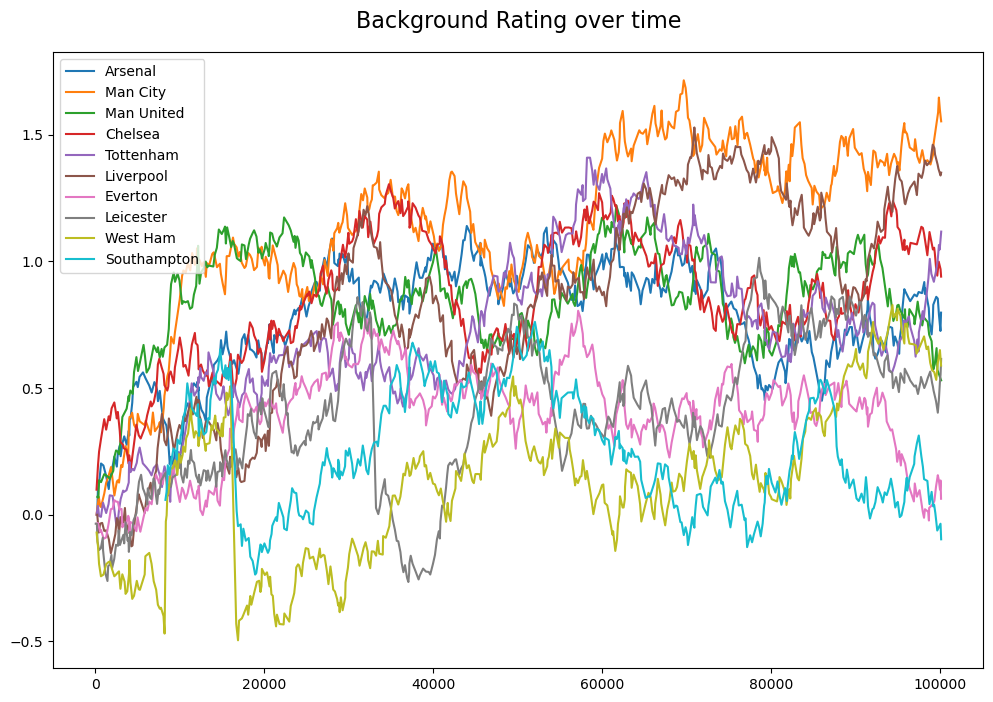

In [13]:
# Main Function

# Load the results data file for seasons 2010-2011 to 2021-2022
df_results = pd.read_csv('../data/season_2010-2022_sorted_compressed_top.csv')

# Load the fixtures data file for the season 2022-2023
df_fixtures = pd.read_csv('../data/season_2022-2023_sorted_top.csv')

# Initialize ratings based on the results data
ratings = initialize_ratings(df_results, df_fixtures)

learning_rate_lambda = 0.04
learning_rate_gamma = 1.0

# Update ratings based on the results data here
ratings, games_with_ratings, training_games = update_ratings_multiple_games(df_results, ratings, learning_rate_lambda, learning_rate_gamma)
#model.C_


plt.figure(figsize=(12, 8))
plt.annotate("Background Rating over time", (0.5, 1.05), xycoords='axes fraction', ha='center', va='center', size=16)
df_ratings = pd.DataFrame(games_with_ratings)
teams = ["Arsenal", "Man City", "Man United", "Chelsea", "Tottenham", "Liverpool", "Everton", "Leicester", "West Ham", "Southampton"]
#for team in df_ratings["team"].unique()[:10]:
for team in teams:
    per_team = df_ratings.loc[df_ratings["team"] == team]
    plt.plot((per_team["home_rating"] + per_team["away_rating"]) / 2, label=team)
plt.legend()
plt.savefig("../images/ratings_over_time232.png", dpi=300)

df_train = pd.DataFrame(training_games)

df_train.to_csv("../data/train232.csv", index=False)

model = train_model(df_train)

# Initialize an empty league tables dictionary and rps list
league_tables = {}
all_rps = []

# Predict the probabilities of home win, draw and away win for the fixtures data
for competition in df_fixtures['Div'].unique():
    competition_fixtures = df_fixtures[df_fixtures['Div'] == competition]
    competition_rps, league_tables = predict_outcomes(competition_fixtures, ratings, learning_rate_lambda, learning_rate_gamma)
    all_rps.extend(competition_rps)  # extend the list with rps scores from the current competition

# Now you can calculate the mean RPS across all competitions
mean_rps = np.mean(all_rps)
print("Average RPS Score across all competitions:", mean_rps)

# Save league tables to file
for competition, league_table in league_tables.items():
    league_table.to_csv(f"../league_tables/{competition}_league_table.csv", index=False)


;

In [14]:
# Print league tables
for competition, league_table in league_tables.items():
    print(f"League table for {competition}:")
    league_table_df = league_table.copy()  # creating a copy to avoid modifying the original data
    league_table_df.index = league_table_df.index + 1
    print(league_table_df)
    league_table_df.index = league_table_df.index - 1

;

League table for B1:
                   team games_played     points
1           Club Brugge           34  67.043082
2                  Genk           34  66.078639
3          St. Gilloise           34  65.884096
4                  Gent           34  62.205961
5               Antwerp           34  62.189352
6            Anderlecht           34  60.825241
7            St Truiden           34  48.120627
8             Charleroi           34  47.612370
9         Cercle Brugge           34  45.708302
10             Standard           34  45.684546
11             Mechelen           34  43.948739
12  Oud-Heverlee Leuven           34  42.325345
13             Kortrijk           34  36.141070
14             Westerlo           34  34.414582
15             Oostende           34  31.759339
16              Waregem           34  29.713399
17                Eupen           34  28.958262
18              Seraing           34  26.634894
League table for E1:
                team games_played     points
1

''

''

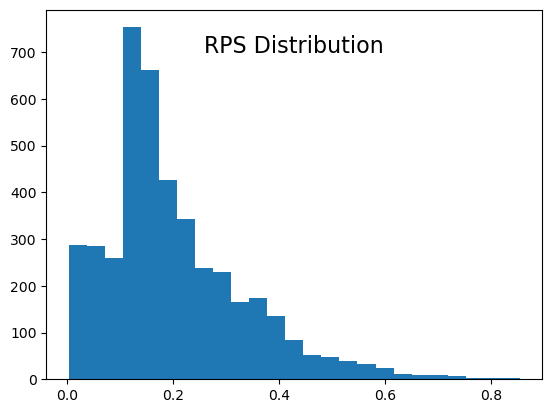

In [24]:
# Plot RPS distribution
plt.annotate("RPS Distribution", (0.5, 0.9), xycoords='axes fraction', ha='center', va='center', size=16)
plt.hist(all_rps, bins=25)
plt.savefig("../images/rps_distribution232.png", dpi=300)



"""
for team, team_ratings in ratings.items():
    print(f"Team: {team}")
    print(f"Background Rating Home: {team_ratings['brH']}")
    print(f"Background Rating Away: {team_ratings['brA']}")
    print(f"Continuous Over/Underperformances: {team_ratings['continuous_overunderperformances']}")
    print()
"""
;

  0%|          | 0/21 [00:00<?, ?it/s]

Teams: {'Gaziantepspor', 'Lecce', 'Granada', 'St. Gilloise', 'Union Berlin', 'Levadeiakos', 'Arouca', 'Chaves', 'Nurnberg', 'Cambuur', 'Fenerbahce', 'Catania', 'Queen of Sth', 'Sheffield Weds', 'St Truiden', 'Auxerre', 'Maritimo', 'Wycombe', 'Elazigspor', 'Panetolikos', 'Antwerp', 'Hearts', 'Karagumruk', 'Westerlo', 'Volendam', 'Yeni Malatyaspor', 'Altay', 'Kavala', 'Brentford', 'Casa Pia', 'Morton', 'Queens Park', 'Besiktas', 'Sampdoria', 'Panionios', 'Karabukspor', 'Sevilla', 'Torino', 'West Brom', 'Vitesse', 'Ergotelis', 'Nacional', 'Siena', 'QPR', 'Blackpool', 'FC Emmen', 'Cardiff', 'Malaga', 'Osasuna', 'Real Madrid', 'Fiorentina', 'Dundee United', 'Ayr', 'Erzurum BB', 'Galatasaray', 'Standard', 'Celtic', 'NAC Breda', 'Mouscron-Peruwelz', 'Bursaspor', 'Levante', 'Valencia', 'Bologna', 'Freiburg', 'Norwich', 'Nancy', 'Lazio', 'Atromitos', 'Monza', 'Willem II ', 'Vallecano', 'Bolton', 'Juventus', 'Rangers', 'Oud-Heverlee Leuven', 'Guimaraes', 'Atalanta', 'Manisaspor', 'Preston', 'Pac

  5%|▍         | 1/21 [00:22<07:31, 22.58s/it]

Average RPS Score for T1: 0.20350314619686904 

Teams: {'Gaziantepspor', 'Lecce', 'Granada', 'St. Gilloise', 'Union Berlin', 'Levadeiakos', 'Arouca', 'Chaves', 'Nurnberg', 'Cambuur', 'Fenerbahce', 'Catania', 'Queen of Sth', 'Sheffield Weds', 'St Truiden', 'Auxerre', 'Maritimo', 'Wycombe', 'Elazigspor', 'Panetolikos', 'Antwerp', 'Hearts', 'Karagumruk', 'Westerlo', 'Volendam', 'Yeni Malatyaspor', 'Altay', 'Kavala', 'Brentford', 'Casa Pia', 'Morton', 'Queens Park', 'Besiktas', 'Sampdoria', 'Panionios', 'Karabukspor', 'Sevilla', 'Torino', 'West Brom', 'Vitesse', 'Ergotelis', 'Nacional', 'Siena', 'QPR', 'Blackpool', 'FC Emmen', 'Cardiff', 'Malaga', 'Osasuna', 'Real Madrid', 'Fiorentina', 'Dundee United', 'Ayr', 'Erzurum BB', 'Galatasaray', 'Standard', 'Celtic', 'NAC Breda', 'Mouscron-Peruwelz', 'Bursaspor', 'Levante', 'Valencia', 'Bologna', 'Freiburg', 'Norwich', 'Nancy', 'Lazio', 'Atromitos', 'Monza', 'Willem II ', 'Vallecano', 'Bolton', 'Juventus', 'Rangers', 'Oud-Heverlee Leuven', 'Guima

 10%|▉         | 2/21 [00:44<07:06, 22.47s/it]

Average RPS Score for T1: 0.2030087354058822 

Teams: {'Gaziantepspor', 'Lecce', 'Granada', 'St. Gilloise', 'Union Berlin', 'Levadeiakos', 'Arouca', 'Chaves', 'Nurnberg', 'Cambuur', 'Fenerbahce', 'Catania', 'Queen of Sth', 'Sheffield Weds', 'St Truiden', 'Auxerre', 'Maritimo', 'Wycombe', 'Elazigspor', 'Panetolikos', 'Antwerp', 'Hearts', 'Karagumruk', 'Westerlo', 'Volendam', 'Yeni Malatyaspor', 'Altay', 'Kavala', 'Brentford', 'Casa Pia', 'Morton', 'Queens Park', 'Besiktas', 'Sampdoria', 'Panionios', 'Karabukspor', 'Sevilla', 'Torino', 'West Brom', 'Vitesse', 'Ergotelis', 'Nacional', 'Siena', 'QPR', 'Blackpool', 'FC Emmen', 'Cardiff', 'Malaga', 'Osasuna', 'Real Madrid', 'Fiorentina', 'Dundee United', 'Ayr', 'Erzurum BB', 'Galatasaray', 'Standard', 'Celtic', 'NAC Breda', 'Mouscron-Peruwelz', 'Bursaspor', 'Levante', 'Valencia', 'Bologna', 'Freiburg', 'Norwich', 'Nancy', 'Lazio', 'Atromitos', 'Monza', 'Willem II ', 'Vallecano', 'Bolton', 'Juventus', 'Rangers', 'Oud-Heverlee Leuven', 'Guimar

 14%|█▍        | 3/21 [01:05<06:31, 21.77s/it]

Average RPS Score for T1: 0.202712222389372 

Teams: {'Gaziantepspor', 'Lecce', 'Granada', 'St. Gilloise', 'Union Berlin', 'Levadeiakos', 'Arouca', 'Chaves', 'Nurnberg', 'Cambuur', 'Fenerbahce', 'Catania', 'Queen of Sth', 'Sheffield Weds', 'St Truiden', 'Auxerre', 'Maritimo', 'Wycombe', 'Elazigspor', 'Panetolikos', 'Antwerp', 'Hearts', 'Karagumruk', 'Westerlo', 'Volendam', 'Yeni Malatyaspor', 'Altay', 'Kavala', 'Brentford', 'Casa Pia', 'Morton', 'Queens Park', 'Besiktas', 'Sampdoria', 'Panionios', 'Karabukspor', 'Sevilla', 'Torino', 'West Brom', 'Vitesse', 'Ergotelis', 'Nacional', 'Siena', 'QPR', 'Blackpool', 'FC Emmen', 'Cardiff', 'Malaga', 'Osasuna', 'Real Madrid', 'Fiorentina', 'Dundee United', 'Ayr', 'Erzurum BB', 'Galatasaray', 'Standard', 'Celtic', 'NAC Breda', 'Mouscron-Peruwelz', 'Bursaspor', 'Levante', 'Valencia', 'Bologna', 'Freiburg', 'Norwich', 'Nancy', 'Lazio', 'Atromitos', 'Monza', 'Willem II ', 'Vallecano', 'Bolton', 'Juventus', 'Rangers', 'Oud-Heverlee Leuven', 'Guimara

 19%|█▉        | 4/21 [01:26<06:05, 21.49s/it]

Average RPS Score for T1: 0.2025220145183679 

Teams: {'Gaziantepspor', 'Lecce', 'Granada', 'St. Gilloise', 'Union Berlin', 'Levadeiakos', 'Arouca', 'Chaves', 'Nurnberg', 'Cambuur', 'Fenerbahce', 'Catania', 'Queen of Sth', 'Sheffield Weds', 'St Truiden', 'Auxerre', 'Maritimo', 'Wycombe', 'Elazigspor', 'Panetolikos', 'Antwerp', 'Hearts', 'Karagumruk', 'Westerlo', 'Volendam', 'Yeni Malatyaspor', 'Altay', 'Kavala', 'Brentford', 'Casa Pia', 'Morton', 'Queens Park', 'Besiktas', 'Sampdoria', 'Panionios', 'Karabukspor', 'Sevilla', 'Torino', 'West Brom', 'Vitesse', 'Ergotelis', 'Nacional', 'Siena', 'QPR', 'Blackpool', 'FC Emmen', 'Cardiff', 'Malaga', 'Osasuna', 'Real Madrid', 'Fiorentina', 'Dundee United', 'Ayr', 'Erzurum BB', 'Galatasaray', 'Standard', 'Celtic', 'NAC Breda', 'Mouscron-Peruwelz', 'Bursaspor', 'Levante', 'Valencia', 'Bologna', 'Freiburg', 'Norwich', 'Nancy', 'Lazio', 'Atromitos', 'Monza', 'Willem II ', 'Vallecano', 'Bolton', 'Juventus', 'Rangers', 'Oud-Heverlee Leuven', 'Guimar

 24%|██▍       | 5/21 [01:47<05:38, 21.18s/it]

Average RPS Score for T1: 0.20255325789782908 

Teams: {'Gaziantepspor', 'Lecce', 'Granada', 'St. Gilloise', 'Union Berlin', 'Levadeiakos', 'Arouca', 'Chaves', 'Nurnberg', 'Cambuur', 'Fenerbahce', 'Catania', 'Queen of Sth', 'Sheffield Weds', 'St Truiden', 'Auxerre', 'Maritimo', 'Wycombe', 'Elazigspor', 'Panetolikos', 'Antwerp', 'Hearts', 'Karagumruk', 'Westerlo', 'Volendam', 'Yeni Malatyaspor', 'Altay', 'Kavala', 'Brentford', 'Casa Pia', 'Morton', 'Queens Park', 'Besiktas', 'Sampdoria', 'Panionios', 'Karabukspor', 'Sevilla', 'Torino', 'West Brom', 'Vitesse', 'Ergotelis', 'Nacional', 'Siena', 'QPR', 'Blackpool', 'FC Emmen', 'Cardiff', 'Malaga', 'Osasuna', 'Real Madrid', 'Fiorentina', 'Dundee United', 'Ayr', 'Erzurum BB', 'Galatasaray', 'Standard', 'Celtic', 'NAC Breda', 'Mouscron-Peruwelz', 'Bursaspor', 'Levante', 'Valencia', 'Bologna', 'Freiburg', 'Norwich', 'Nancy', 'Lazio', 'Atromitos', 'Monza', 'Willem II ', 'Vallecano', 'Bolton', 'Juventus', 'Rangers', 'Oud-Heverlee Leuven', 'Guima

 29%|██▊       | 6/21 [02:08<05:15, 21.06s/it]

Average RPS Score for T1: 0.20244747716922137 

Teams: {'Gaziantepspor', 'Lecce', 'Granada', 'St. Gilloise', 'Union Berlin', 'Levadeiakos', 'Arouca', 'Chaves', 'Nurnberg', 'Cambuur', 'Fenerbahce', 'Catania', 'Queen of Sth', 'Sheffield Weds', 'St Truiden', 'Auxerre', 'Maritimo', 'Wycombe', 'Elazigspor', 'Panetolikos', 'Antwerp', 'Hearts', 'Karagumruk', 'Westerlo', 'Volendam', 'Yeni Malatyaspor', 'Altay', 'Kavala', 'Brentford', 'Casa Pia', 'Morton', 'Queens Park', 'Besiktas', 'Sampdoria', 'Panionios', 'Karabukspor', 'Sevilla', 'Torino', 'West Brom', 'Vitesse', 'Ergotelis', 'Nacional', 'Siena', 'QPR', 'Blackpool', 'FC Emmen', 'Cardiff', 'Malaga', 'Osasuna', 'Real Madrid', 'Fiorentina', 'Dundee United', 'Ayr', 'Erzurum BB', 'Galatasaray', 'Standard', 'Celtic', 'NAC Breda', 'Mouscron-Peruwelz', 'Bursaspor', 'Levante', 'Valencia', 'Bologna', 'Freiburg', 'Norwich', 'Nancy', 'Lazio', 'Atromitos', 'Monza', 'Willem II ', 'Vallecano', 'Bolton', 'Juventus', 'Rangers', 'Oud-Heverlee Leuven', 'Guima

 33%|███▎      | 7/21 [02:28<04:52, 20.90s/it]

Average RPS Score for T1: 0.20252946055028012 

Teams: {'Gaziantepspor', 'Lecce', 'Granada', 'St. Gilloise', 'Union Berlin', 'Levadeiakos', 'Arouca', 'Chaves', 'Nurnberg', 'Cambuur', 'Fenerbahce', 'Catania', 'Queen of Sth', 'Sheffield Weds', 'St Truiden', 'Auxerre', 'Maritimo', 'Wycombe', 'Elazigspor', 'Panetolikos', 'Antwerp', 'Hearts', 'Karagumruk', 'Westerlo', 'Volendam', 'Yeni Malatyaspor', 'Altay', 'Kavala', 'Brentford', 'Casa Pia', 'Morton', 'Queens Park', 'Besiktas', 'Sampdoria', 'Panionios', 'Karabukspor', 'Sevilla', 'Torino', 'West Brom', 'Vitesse', 'Ergotelis', 'Nacional', 'Siena', 'QPR', 'Blackpool', 'FC Emmen', 'Cardiff', 'Malaga', 'Osasuna', 'Real Madrid', 'Fiorentina', 'Dundee United', 'Ayr', 'Erzurum BB', 'Galatasaray', 'Standard', 'Celtic', 'NAC Breda', 'Mouscron-Peruwelz', 'Bursaspor', 'Levante', 'Valencia', 'Bologna', 'Freiburg', 'Norwich', 'Nancy', 'Lazio', 'Atromitos', 'Monza', 'Willem II ', 'Vallecano', 'Bolton', 'Juventus', 'Rangers', 'Oud-Heverlee Leuven', 'Guima

 38%|███▊      | 8/21 [02:49<04:29, 20.74s/it]

Average RPS Score for T1: 0.20335653765768574 

Teams: {'Gaziantepspor', 'Lecce', 'Granada', 'St. Gilloise', 'Union Berlin', 'Levadeiakos', 'Arouca', 'Chaves', 'Nurnberg', 'Cambuur', 'Fenerbahce', 'Catania', 'Queen of Sth', 'Sheffield Weds', 'St Truiden', 'Auxerre', 'Maritimo', 'Wycombe', 'Elazigspor', 'Panetolikos', 'Antwerp', 'Hearts', 'Karagumruk', 'Westerlo', 'Volendam', 'Yeni Malatyaspor', 'Altay', 'Kavala', 'Brentford', 'Casa Pia', 'Morton', 'Queens Park', 'Besiktas', 'Sampdoria', 'Panionios', 'Karabukspor', 'Sevilla', 'Torino', 'West Brom', 'Vitesse', 'Ergotelis', 'Nacional', 'Siena', 'QPR', 'Blackpool', 'FC Emmen', 'Cardiff', 'Malaga', 'Osasuna', 'Real Madrid', 'Fiorentina', 'Dundee United', 'Ayr', 'Erzurum BB', 'Galatasaray', 'Standard', 'Celtic', 'NAC Breda', 'Mouscron-Peruwelz', 'Bursaspor', 'Levante', 'Valencia', 'Bologna', 'Freiburg', 'Norwich', 'Nancy', 'Lazio', 'Atromitos', 'Monza', 'Willem II ', 'Vallecano', 'Bolton', 'Juventus', 'Rangers', 'Oud-Heverlee Leuven', 'Guima

 43%|████▎     | 9/21 [03:09<04:07, 20.66s/it]

Average RPS Score for T1: 0.20280387322664378 

Teams: {'Gaziantepspor', 'Lecce', 'Granada', 'St. Gilloise', 'Union Berlin', 'Levadeiakos', 'Arouca', 'Chaves', 'Nurnberg', 'Cambuur', 'Fenerbahce', 'Catania', 'Queen of Sth', 'Sheffield Weds', 'St Truiden', 'Auxerre', 'Maritimo', 'Wycombe', 'Elazigspor', 'Panetolikos', 'Antwerp', 'Hearts', 'Karagumruk', 'Westerlo', 'Volendam', 'Yeni Malatyaspor', 'Altay', 'Kavala', 'Brentford', 'Casa Pia', 'Morton', 'Queens Park', 'Besiktas', 'Sampdoria', 'Panionios', 'Karabukspor', 'Sevilla', 'Torino', 'West Brom', 'Vitesse', 'Ergotelis', 'Nacional', 'Siena', 'QPR', 'Blackpool', 'FC Emmen', 'Cardiff', 'Malaga', 'Osasuna', 'Real Madrid', 'Fiorentina', 'Dundee United', 'Ayr', 'Erzurum BB', 'Galatasaray', 'Standard', 'Celtic', 'NAC Breda', 'Mouscron-Peruwelz', 'Bursaspor', 'Levante', 'Valencia', 'Bologna', 'Freiburg', 'Norwich', 'Nancy', 'Lazio', 'Atromitos', 'Monza', 'Willem II ', 'Vallecano', 'Bolton', 'Juventus', 'Rangers', 'Oud-Heverlee Leuven', 'Guima

 48%|████▊     | 10/21 [03:31<03:50, 20.95s/it]

Average RPS Score for T1: 0.20257657829238088 

Teams: {'Gaziantepspor', 'Lecce', 'Granada', 'St. Gilloise', 'Union Berlin', 'Levadeiakos', 'Arouca', 'Chaves', 'Nurnberg', 'Cambuur', 'Fenerbahce', 'Catania', 'Queen of Sth', 'Sheffield Weds', 'St Truiden', 'Auxerre', 'Maritimo', 'Wycombe', 'Elazigspor', 'Panetolikos', 'Antwerp', 'Hearts', 'Karagumruk', 'Westerlo', 'Volendam', 'Yeni Malatyaspor', 'Altay', 'Kavala', 'Brentford', 'Casa Pia', 'Morton', 'Queens Park', 'Besiktas', 'Sampdoria', 'Panionios', 'Karabukspor', 'Sevilla', 'Torino', 'West Brom', 'Vitesse', 'Ergotelis', 'Nacional', 'Siena', 'QPR', 'Blackpool', 'FC Emmen', 'Cardiff', 'Malaga', 'Osasuna', 'Real Madrid', 'Fiorentina', 'Dundee United', 'Ayr', 'Erzurum BB', 'Galatasaray', 'Standard', 'Celtic', 'NAC Breda', 'Mouscron-Peruwelz', 'Bursaspor', 'Levante', 'Valencia', 'Bologna', 'Freiburg', 'Norwich', 'Nancy', 'Lazio', 'Atromitos', 'Monza', 'Willem II ', 'Vallecano', 'Bolton', 'Juventus', 'Rangers', 'Oud-Heverlee Leuven', 'Guima

 52%|█████▏    | 11/21 [03:53<03:33, 21.35s/it]

Average RPS Score for T1: 0.20242426566276886 

Teams: {'Gaziantepspor', 'Lecce', 'Granada', 'St. Gilloise', 'Union Berlin', 'Levadeiakos', 'Arouca', 'Chaves', 'Nurnberg', 'Cambuur', 'Fenerbahce', 'Catania', 'Queen of Sth', 'Sheffield Weds', 'St Truiden', 'Auxerre', 'Maritimo', 'Wycombe', 'Elazigspor', 'Panetolikos', 'Antwerp', 'Hearts', 'Karagumruk', 'Westerlo', 'Volendam', 'Yeni Malatyaspor', 'Altay', 'Kavala', 'Brentford', 'Casa Pia', 'Morton', 'Queens Park', 'Besiktas', 'Sampdoria', 'Panionios', 'Karabukspor', 'Sevilla', 'Torino', 'West Brom', 'Vitesse', 'Ergotelis', 'Nacional', 'Siena', 'QPR', 'Blackpool', 'FC Emmen', 'Cardiff', 'Malaga', 'Osasuna', 'Real Madrid', 'Fiorentina', 'Dundee United', 'Ayr', 'Erzurum BB', 'Galatasaray', 'Standard', 'Celtic', 'NAC Breda', 'Mouscron-Peruwelz', 'Bursaspor', 'Levante', 'Valencia', 'Bologna', 'Freiburg', 'Norwich', 'Nancy', 'Lazio', 'Atromitos', 'Monza', 'Willem II ', 'Vallecano', 'Bolton', 'Juventus', 'Rangers', 'Oud-Heverlee Leuven', 'Guima

 57%|█████▋    | 12/21 [04:15<03:13, 21.52s/it]

Average RPS Score for T1: 0.20243046351075283 

Teams: {'Gaziantepspor', 'Lecce', 'Granada', 'St. Gilloise', 'Union Berlin', 'Levadeiakos', 'Arouca', 'Chaves', 'Nurnberg', 'Cambuur', 'Fenerbahce', 'Catania', 'Queen of Sth', 'Sheffield Weds', 'St Truiden', 'Auxerre', 'Maritimo', 'Wycombe', 'Elazigspor', 'Panetolikos', 'Antwerp', 'Hearts', 'Karagumruk', 'Westerlo', 'Volendam', 'Yeni Malatyaspor', 'Altay', 'Kavala', 'Brentford', 'Casa Pia', 'Morton', 'Queens Park', 'Besiktas', 'Sampdoria', 'Panionios', 'Karabukspor', 'Sevilla', 'Torino', 'West Brom', 'Vitesse', 'Ergotelis', 'Nacional', 'Siena', 'QPR', 'Blackpool', 'FC Emmen', 'Cardiff', 'Malaga', 'Osasuna', 'Real Madrid', 'Fiorentina', 'Dundee United', 'Ayr', 'Erzurum BB', 'Galatasaray', 'Standard', 'Celtic', 'NAC Breda', 'Mouscron-Peruwelz', 'Bursaspor', 'Levante', 'Valencia', 'Bologna', 'Freiburg', 'Norwich', 'Nancy', 'Lazio', 'Atromitos', 'Monza', 'Willem II ', 'Vallecano', 'Bolton', 'Juventus', 'Rangers', 'Oud-Heverlee Leuven', 'Guima

 62%|██████▏   | 13/21 [04:37<02:51, 21.47s/it]

Average RPS Score for T1: 0.20253189475698127 

Teams: {'Gaziantepspor', 'Lecce', 'Granada', 'St. Gilloise', 'Union Berlin', 'Levadeiakos', 'Arouca', 'Chaves', 'Nurnberg', 'Cambuur', 'Fenerbahce', 'Catania', 'Queen of Sth', 'Sheffield Weds', 'St Truiden', 'Auxerre', 'Maritimo', 'Wycombe', 'Elazigspor', 'Panetolikos', 'Antwerp', 'Hearts', 'Karagumruk', 'Westerlo', 'Volendam', 'Yeni Malatyaspor', 'Altay', 'Kavala', 'Brentford', 'Casa Pia', 'Morton', 'Queens Park', 'Besiktas', 'Sampdoria', 'Panionios', 'Karabukspor', 'Sevilla', 'Torino', 'West Brom', 'Vitesse', 'Ergotelis', 'Nacional', 'Siena', 'QPR', 'Blackpool', 'FC Emmen', 'Cardiff', 'Malaga', 'Osasuna', 'Real Madrid', 'Fiorentina', 'Dundee United', 'Ayr', 'Erzurum BB', 'Galatasaray', 'Standard', 'Celtic', 'NAC Breda', 'Mouscron-Peruwelz', 'Bursaspor', 'Levante', 'Valencia', 'Bologna', 'Freiburg', 'Norwich', 'Nancy', 'Lazio', 'Atromitos', 'Monza', 'Willem II ', 'Vallecano', 'Bolton', 'Juventus', 'Rangers', 'Oud-Heverlee Leuven', 'Guima

 67%|██████▋   | 14/21 [04:57<02:28, 21.19s/it]

Average RPS Score for T1: 0.20260030084937483 

Teams: {'Gaziantepspor', 'Lecce', 'Granada', 'St. Gilloise', 'Union Berlin', 'Levadeiakos', 'Arouca', 'Chaves', 'Nurnberg', 'Cambuur', 'Fenerbahce', 'Catania', 'Queen of Sth', 'Sheffield Weds', 'St Truiden', 'Auxerre', 'Maritimo', 'Wycombe', 'Elazigspor', 'Panetolikos', 'Antwerp', 'Hearts', 'Karagumruk', 'Westerlo', 'Volendam', 'Yeni Malatyaspor', 'Altay', 'Kavala', 'Brentford', 'Casa Pia', 'Morton', 'Queens Park', 'Besiktas', 'Sampdoria', 'Panionios', 'Karabukspor', 'Sevilla', 'Torino', 'West Brom', 'Vitesse', 'Ergotelis', 'Nacional', 'Siena', 'QPR', 'Blackpool', 'FC Emmen', 'Cardiff', 'Malaga', 'Osasuna', 'Real Madrid', 'Fiorentina', 'Dundee United', 'Ayr', 'Erzurum BB', 'Galatasaray', 'Standard', 'Celtic', 'NAC Breda', 'Mouscron-Peruwelz', 'Bursaspor', 'Levante', 'Valencia', 'Bologna', 'Freiburg', 'Norwich', 'Nancy', 'Lazio', 'Atromitos', 'Monza', 'Willem II ', 'Vallecano', 'Bolton', 'Juventus', 'Rangers', 'Oud-Heverlee Leuven', 'Guima

 71%|███████▏  | 15/21 [05:18<02:05, 20.98s/it]

Average RPS Score for T1: 0.20324340951794673 

Teams: {'Gaziantepspor', 'Lecce', 'Granada', 'St. Gilloise', 'Union Berlin', 'Levadeiakos', 'Arouca', 'Chaves', 'Nurnberg', 'Cambuur', 'Fenerbahce', 'Catania', 'Queen of Sth', 'Sheffield Weds', 'St Truiden', 'Auxerre', 'Maritimo', 'Wycombe', 'Elazigspor', 'Panetolikos', 'Antwerp', 'Hearts', 'Karagumruk', 'Westerlo', 'Volendam', 'Yeni Malatyaspor', 'Altay', 'Kavala', 'Brentford', 'Casa Pia', 'Morton', 'Queens Park', 'Besiktas', 'Sampdoria', 'Panionios', 'Karabukspor', 'Sevilla', 'Torino', 'West Brom', 'Vitesse', 'Ergotelis', 'Nacional', 'Siena', 'QPR', 'Blackpool', 'FC Emmen', 'Cardiff', 'Malaga', 'Osasuna', 'Real Madrid', 'Fiorentina', 'Dundee United', 'Ayr', 'Erzurum BB', 'Galatasaray', 'Standard', 'Celtic', 'NAC Breda', 'Mouscron-Peruwelz', 'Bursaspor', 'Levante', 'Valencia', 'Bologna', 'Freiburg', 'Norwich', 'Nancy', 'Lazio', 'Atromitos', 'Monza', 'Willem II ', 'Vallecano', 'Bolton', 'Juventus', 'Rangers', 'Oud-Heverlee Leuven', 'Guima

 76%|███████▌  | 16/21 [05:38<01:44, 20.83s/it]

Average RPS Score for T1: 0.20278756349307112 

Teams: {'Gaziantepspor', 'Lecce', 'Granada', 'St. Gilloise', 'Union Berlin', 'Levadeiakos', 'Arouca', 'Chaves', 'Nurnberg', 'Cambuur', 'Fenerbahce', 'Catania', 'Queen of Sth', 'Sheffield Weds', 'St Truiden', 'Auxerre', 'Maritimo', 'Wycombe', 'Elazigspor', 'Panetolikos', 'Antwerp', 'Hearts', 'Karagumruk', 'Westerlo', 'Volendam', 'Yeni Malatyaspor', 'Altay', 'Kavala', 'Brentford', 'Casa Pia', 'Morton', 'Queens Park', 'Besiktas', 'Sampdoria', 'Panionios', 'Karabukspor', 'Sevilla', 'Torino', 'West Brom', 'Vitesse', 'Ergotelis', 'Nacional', 'Siena', 'QPR', 'Blackpool', 'FC Emmen', 'Cardiff', 'Malaga', 'Osasuna', 'Real Madrid', 'Fiorentina', 'Dundee United', 'Ayr', 'Erzurum BB', 'Galatasaray', 'Standard', 'Celtic', 'NAC Breda', 'Mouscron-Peruwelz', 'Bursaspor', 'Levante', 'Valencia', 'Bologna', 'Freiburg', 'Norwich', 'Nancy', 'Lazio', 'Atromitos', 'Monza', 'Willem II ', 'Vallecano', 'Bolton', 'Juventus', 'Rangers', 'Oud-Heverlee Leuven', 'Guima

 81%|████████  | 17/21 [05:59<01:23, 20.95s/it]

Average RPS Score for T1: 0.20248584394408733 

Teams: {'Gaziantepspor', 'Lecce', 'Granada', 'St. Gilloise', 'Union Berlin', 'Levadeiakos', 'Arouca', 'Chaves', 'Nurnberg', 'Cambuur', 'Fenerbahce', 'Catania', 'Queen of Sth', 'Sheffield Weds', 'St Truiden', 'Auxerre', 'Maritimo', 'Wycombe', 'Elazigspor', 'Panetolikos', 'Antwerp', 'Hearts', 'Karagumruk', 'Westerlo', 'Volendam', 'Yeni Malatyaspor', 'Altay', 'Kavala', 'Brentford', 'Casa Pia', 'Morton', 'Queens Park', 'Besiktas', 'Sampdoria', 'Panionios', 'Karabukspor', 'Sevilla', 'Torino', 'West Brom', 'Vitesse', 'Ergotelis', 'Nacional', 'Siena', 'QPR', 'Blackpool', 'FC Emmen', 'Cardiff', 'Malaga', 'Osasuna', 'Real Madrid', 'Fiorentina', 'Dundee United', 'Ayr', 'Erzurum BB', 'Galatasaray', 'Standard', 'Celtic', 'NAC Breda', 'Mouscron-Peruwelz', 'Bursaspor', 'Levante', 'Valencia', 'Bologna', 'Freiburg', 'Norwich', 'Nancy', 'Lazio', 'Atromitos', 'Monza', 'Willem II ', 'Vallecano', 'Bolton', 'Juventus', 'Rangers', 'Oud-Heverlee Leuven', 'Guima

 86%|████████▌ | 18/21 [06:20<01:02, 20.74s/it]

Average RPS Score for T1: 0.20233202493926117 

Teams: {'Gaziantepspor', 'Lecce', 'Granada', 'St. Gilloise', 'Union Berlin', 'Levadeiakos', 'Arouca', 'Chaves', 'Nurnberg', 'Cambuur', 'Fenerbahce', 'Catania', 'Queen of Sth', 'Sheffield Weds', 'St Truiden', 'Auxerre', 'Maritimo', 'Wycombe', 'Elazigspor', 'Panetolikos', 'Antwerp', 'Hearts', 'Karagumruk', 'Westerlo', 'Volendam', 'Yeni Malatyaspor', 'Altay', 'Kavala', 'Brentford', 'Casa Pia', 'Morton', 'Queens Park', 'Besiktas', 'Sampdoria', 'Panionios', 'Karabukspor', 'Sevilla', 'Torino', 'West Brom', 'Vitesse', 'Ergotelis', 'Nacional', 'Siena', 'QPR', 'Blackpool', 'FC Emmen', 'Cardiff', 'Malaga', 'Osasuna', 'Real Madrid', 'Fiorentina', 'Dundee United', 'Ayr', 'Erzurum BB', 'Galatasaray', 'Standard', 'Celtic', 'NAC Breda', 'Mouscron-Peruwelz', 'Bursaspor', 'Levante', 'Valencia', 'Bologna', 'Freiburg', 'Norwich', 'Nancy', 'Lazio', 'Atromitos', 'Monza', 'Willem II ', 'Vallecano', 'Bolton', 'Juventus', 'Rangers', 'Oud-Heverlee Leuven', 'Guima

 90%|█████████ | 19/21 [06:40<00:41, 20.71s/it]

Average RPS Score for T1: 0.20232081370865118 

Teams: {'Gaziantepspor', 'Lecce', 'Granada', 'St. Gilloise', 'Union Berlin', 'Levadeiakos', 'Arouca', 'Chaves', 'Nurnberg', 'Cambuur', 'Fenerbahce', 'Catania', 'Queen of Sth', 'Sheffield Weds', 'St Truiden', 'Auxerre', 'Maritimo', 'Wycombe', 'Elazigspor', 'Panetolikos', 'Antwerp', 'Hearts', 'Karagumruk', 'Westerlo', 'Volendam', 'Yeni Malatyaspor', 'Altay', 'Kavala', 'Brentford', 'Casa Pia', 'Morton', 'Queens Park', 'Besiktas', 'Sampdoria', 'Panionios', 'Karabukspor', 'Sevilla', 'Torino', 'West Brom', 'Vitesse', 'Ergotelis', 'Nacional', 'Siena', 'QPR', 'Blackpool', 'FC Emmen', 'Cardiff', 'Malaga', 'Osasuna', 'Real Madrid', 'Fiorentina', 'Dundee United', 'Ayr', 'Erzurum BB', 'Galatasaray', 'Standard', 'Celtic', 'NAC Breda', 'Mouscron-Peruwelz', 'Bursaspor', 'Levante', 'Valencia', 'Bologna', 'Freiburg', 'Norwich', 'Nancy', 'Lazio', 'Atromitos', 'Monza', 'Willem II ', 'Vallecano', 'Bolton', 'Juventus', 'Rangers', 'Oud-Heverlee Leuven', 'Guima

 95%|█████████▌| 20/21 [07:01<00:20, 20.84s/it]

Average RPS Score for T1: 0.20235964520186592 

Teams: {'Gaziantepspor', 'Lecce', 'Granada', 'St. Gilloise', 'Union Berlin', 'Levadeiakos', 'Arouca', 'Chaves', 'Nurnberg', 'Cambuur', 'Fenerbahce', 'Catania', 'Queen of Sth', 'Sheffield Weds', 'St Truiden', 'Auxerre', 'Maritimo', 'Wycombe', 'Elazigspor', 'Panetolikos', 'Antwerp', 'Hearts', 'Karagumruk', 'Westerlo', 'Volendam', 'Yeni Malatyaspor', 'Altay', 'Kavala', 'Brentford', 'Casa Pia', 'Morton', 'Queens Park', 'Besiktas', 'Sampdoria', 'Panionios', 'Karabukspor', 'Sevilla', 'Torino', 'West Brom', 'Vitesse', 'Ergotelis', 'Nacional', 'Siena', 'QPR', 'Blackpool', 'FC Emmen', 'Cardiff', 'Malaga', 'Osasuna', 'Real Madrid', 'Fiorentina', 'Dundee United', 'Ayr', 'Erzurum BB', 'Galatasaray', 'Standard', 'Celtic', 'NAC Breda', 'Mouscron-Peruwelz', 'Bursaspor', 'Levante', 'Valencia', 'Bologna', 'Freiburg', 'Norwich', 'Nancy', 'Lazio', 'Atromitos', 'Monza', 'Willem II ', 'Vallecano', 'Bolton', 'Juventus', 'Rangers', 'Oud-Heverlee Leuven', 'Guima

100%|██████████| 21/21 [07:22<00:00, 21.08s/it]

Average RPS Score for T1: 0.20247820747006212 

Best score: 0.20232081370865118
Best params: {'learning_rate_gamma': 1.0, 'learning_rate_lambda': 0.04000000000000001}


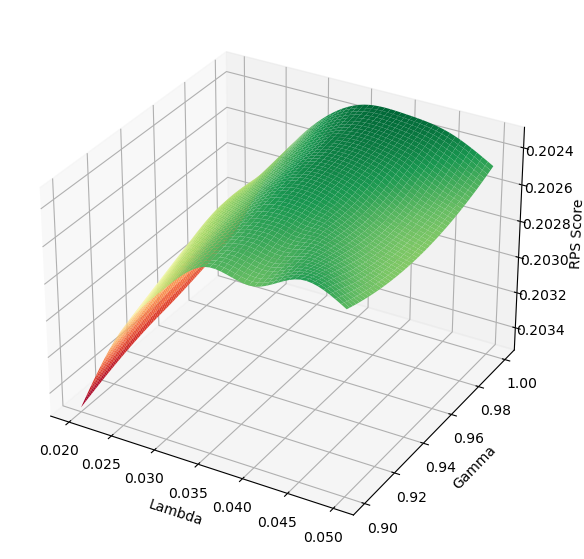

/var/folders/js/lg3nlt2956z9yc23wzld8xm80000gn/T/ipykernel_56155/44899875.py:77: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap_reversed = plt.cm.get_cmap('RdYlGn_r')  # Reversed Red-Yellow-Green colormap


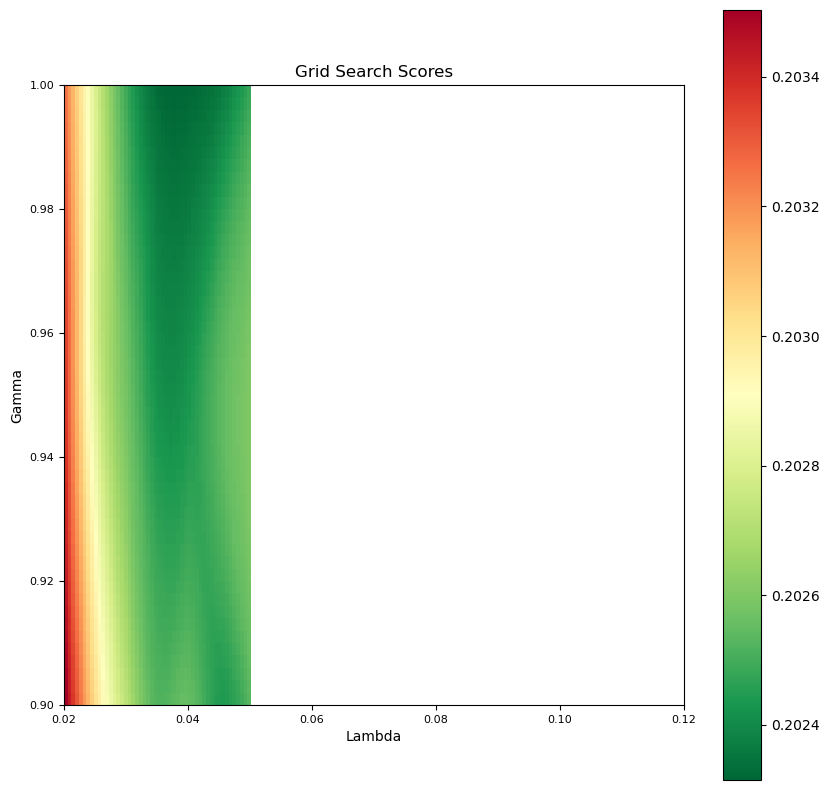

/var/folders/js/lg3nlt2956z9yc23wzld8xm80000gn/T/ipykernel_56155/44899875.py:96: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  pivot_table = df_gs_results.pivot('learning_rate_lambda', 'learning_rate_gamma', 'score')


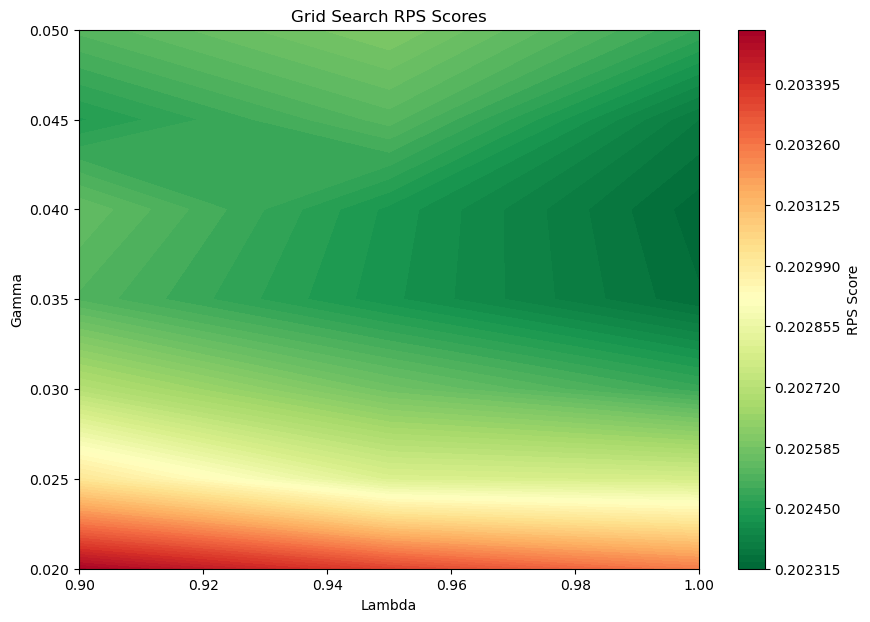

''

In [26]:
"""
# Define a parameter grid with the ranges for your parameters
param_grid = {
    'learning_rate_lambda': np.arange(0.02, 0.051, 0.005),
    'learning_rate_gamma': np.arange(0.9, 1.01, 0.05)
}

# Create a ParameterGrid object from the dictionary
grid = ParameterGrid(param_grid)

# Initialize the best_score variable and best_params dictionary
best_score = float('inf')  # assuming lower scores are better; use -float('inf') if higher scores are better
best_params = {}

# Create an empty list to store the results
gs_results = []

# Loop over the parameter combinations
for params in tqdm.tqdm(grid):
    ratings = initialize_ratings(df_results, df_fixtures)

    # Update your learning rates
    learning_rate_lambda = params['learning_rate_lambda']
    learning_rate_gamma = params['learning_rate_gamma']

    # Re-train model with the new parameters
    ratings, games_with_ratings, training_games = update_ratings_multiple_games(df_results, ratings, learning_rate_lambda, learning_rate_gamma)

    df_train = pd.DataFrame(training_games)
    df_train.to_csv("../data/train232.csv", index=False)
    model = train_model(df_train)

    all_rps, league_tables = predict_outcomes(df_fixtures, ratings, learning_rate_lambda, learning_rate_gamma)
    score = np.mean(all_rps)

    # If the current score is better than the best_score, update best_score and best_params
    if score < best_score:
        best_score = score
        best_params = params

    # Store the current score and parameters
    gs_results.append({
        'learning_rate_lambda': learning_rate_lambda,
        'learning_rate_gamma': learning_rate_gamma,
        'score': score,
    })

print(f'Best score: {best_score}')
print(f'Best params: {best_params}')

# Convert the gs_results to a DataFrame and plot them
df_gs_results = pd.DataFrame(gs_results)

# Define grid of x, y values
lambda_range = np.linspace(df_gs_results['learning_rate_lambda'].min(), df_gs_results['learning_rate_lambda'].max(), num=50)
gamma_range = np.linspace(df_gs_results['learning_rate_gamma'].min(), df_gs_results['learning_rate_gamma'].max(), num=50)
lambda_grid, gamma_grid = np.meshgrid(lambda_range, gamma_range)

# Interpolate z values for this grid
rps_grid = griddata((df_gs_results['learning_rate_lambda'], df_gs_results['learning_rate_gamma']), df_gs_results['score'], (lambda_grid, gamma_grid), method='cubic')

# Create 3D surface plot
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(lambda_grid, gamma_grid, rps_grid, cmap='RdYlGn_r', edgecolor='none')
ax.set_xlabel('Lambda')
ax.set_ylabel('Gamma')
ax.set_zlabel('RPS Score', fontsize=10, labelpad=5)
ax.invert_zaxis()  # To make lower scores appear higher
#fig.colorbar(surf)
plt.savefig("../images/3d_plot_gs232.png", dpi=300)
plt.show()

# Create 2D plot with colormap
plt.figure(figsize=(10, 10))  # Adjust figsize to your preference to make the plot square
plt.title('Grid Search Scores')

cmap_reversed = plt.cm.get_cmap('RdYlGn_r')  # Reversed Red-Yellow-Green colormap

# Here we store the image object returned by imshow
im = plt.imshow(rps_grid, interpolation='nearest', cmap=cmap_reversed,
           extent=(param_grid['learning_rate_lambda'].min(), param_grid['learning_rate_lambda'].max(), param_grid['learning_rate_gamma'].min(), param_grid['learning_rate_gamma'].max()), origin='lower')

# We use the stored image object for the colorbar
plt.colorbar(im, cmap=cmap_reversed)

plt.axis('square')  # This will enforce a square aspect ratio

plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.xlabel("Lambda")
plt.ylabel("Gamma")
plt.savefig("../images/2d_plot_heat_gs232.png", dpi=300)
plt.show()

# Convert grid search results into a pivot table for plotting
pivot_table = df_gs_results.pivot('learning_rate_lambda', 'learning_rate_gamma', 'score')

# Create contour plot
plt.figure(figsize=(10,7))
contour_plot = plt.contourf(pivot_table.columns, pivot_table.index, pivot_table.values, cmap='RdYlGn_r', levels=100)
plt.title('Grid Search RPS Scores')
plt.xlabel('Lambda')
plt.ylabel('Gamma')

# Add a colorbar
cbar = plt.colorbar(contour_plot)
cbar.ax.set_ylabel('RPS Score')

plt.savefig("../images/2d_plot_contour_gs232.png", dpi=300)
plt.show()
"""
;